In [1]:
import pandas as pd
import os
from os import chdir as cd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import random
from sklearn.model_selection import train_test_split
import tensorflow as tf

2025-02-06 16:01:12.476732: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-02-06 16:01:14.097358: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/jacquin/anaconda3/lib/python3.9/site-packages/cv2/../../lib64:
2025-02-06 16:01:14.097649: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/jacquin/anaconda3/lib/python3.9/site-packages/cv2/../..

In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  0


2025-02-06 16:01:15.411917: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2025-02-06 16:01:15.411960: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: jacquin-MS-7B84
2025-02-06 16:01:15.411968: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: jacquin-MS-7B84
2025-02-06 16:01:15.412215: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 535.183.1
2025-02-06 16:01:15.412241: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 535.183.1
2025-02-06 16:01:15.412248: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 535.183.1


In [3]:
cd ("/media/jacquin/STOCKAGE/DATA_SCIENCE/DATA_VALEO/")

### Data loading

In [4]:
df_train = pd.read_csv("Train_Inputs.csv",sep=";")

In [5]:
df_train.head(10)

,images,Unnamed: 1,Unnamed: 2
0,AE00474_105028_00_4_3_2001.jpg,NaN,NaN
1,AE00305_043057_00_2_4_2001.jpg,NaN,NaN
2,AE00191_071651_00_2_2_2001.jpg,NaN,NaN
3,AE00191_103659_00_2_1_2001.jpg,NaN,NaN
4,AE00227_204647_00_3_4_2001.jpg,NaN,NaN
5,AE00370_023945_00_4_3_2001.jpg,NaN,NaN
6,AE00382_062529_00_3_1_2001.jpg,NaN,NaN
7,AE00354_062933_00_3_4_2001.jpg,NaN,NaN
8,AE00402_143834_00_1_2_2001.jpg,NaN,NaN
9,AE00191_070306_00_3_4_2001.jpg,NaN,NaN


In [6]:
df_train_data = pd.read_csv("train_data_labels.csv")

In [7]:
df_train_data.head(10)

,images,labels
0,AE00474_105028_00_4_3_2001.jpg,0
1,AE00305_043057_00_2_4_2001.jpg,1
2,AE00191_071651_00_2_2_2001.jpg,1
3,AE00191_103659_00_2_1_2001.jpg,1
4,AE00227_204647_00_3_4_2001.jpg,1
5,AE00370_023945_00_4_3_2001.jpg,0
6,AE00382_062529_00_3_1_2001.jpg,1
7,AE00354_062933_00_3_4_2001.jpg,1
8,AE00402_143834_00_1_2_2001.jpg,0
9,AE00191_070306_00_3_4_2001.jpg,0


In [8]:
df_train_data.describe()

,labels
count,10609.000000
mean,0.620417
std,0.485306
min,0.000000
25%,0.000000
50%,1.000000
75%,1.000000
max,1.000000


In [9]:
df_train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10609 entries, 0 to 10608
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   images  10609 non-null  object
 1   labels  10609 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 165.9+ KB


### Labels distribution

In [10]:
df_train_data["labels"].value_counts(normalize=True)

1    0.620417
0    0.379583
Name: labels, dtype: float64

/home/jacquin/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


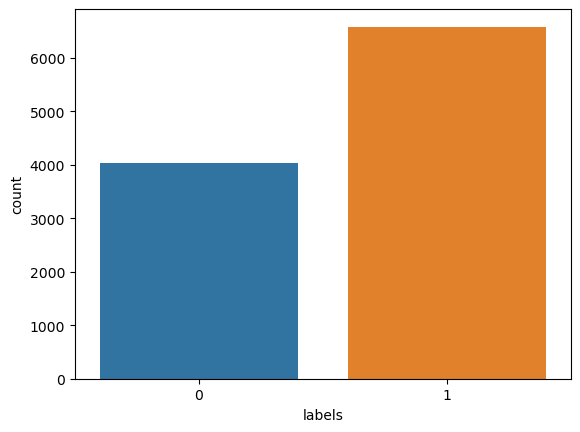

In [11]:
sns.countplot(df_train_data["labels"]);

#### We have almost twice defective parts non confirmed by the operator.

### Examples of images

0: defect confirmed by operator  
1: defect not confirmed by operator

In [16]:
list_non_confirmed = df_train_data[df_train_data["labels"]==1]["images"].reset_index()

In [17]:
cd ("./Train_Dataset")

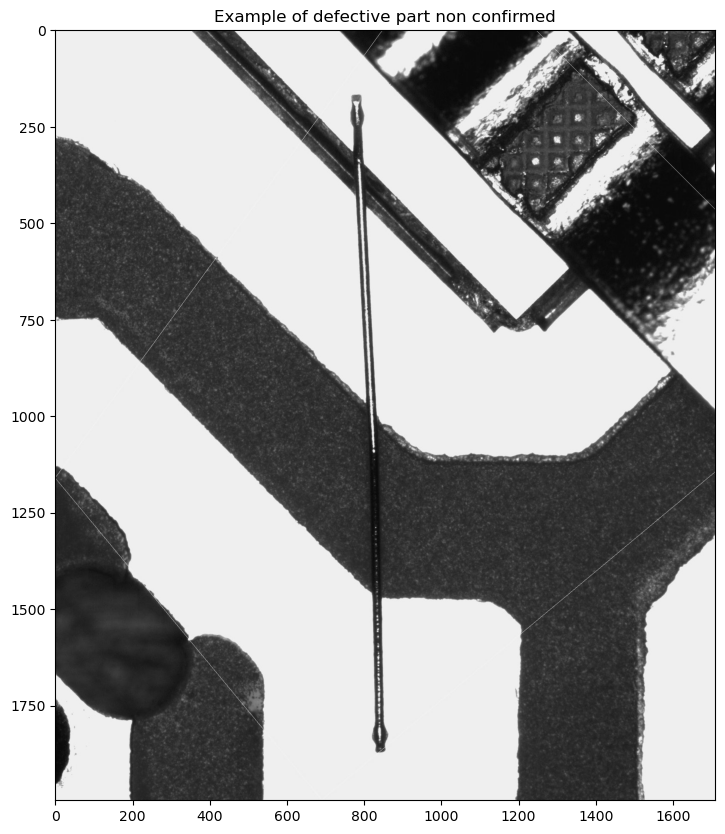

In [18]:
file = random.choice(list_non_confirmed["images"])
plt.figure(figsize=(10,10))
plt.title ("Example of defective part non confirmed")
img1 = cv2.imread(file)
plt.imshow(img1);

In [19]:
list_confirmed = df_train_data[df_train_data["labels"]==0]["images"].reset_index()

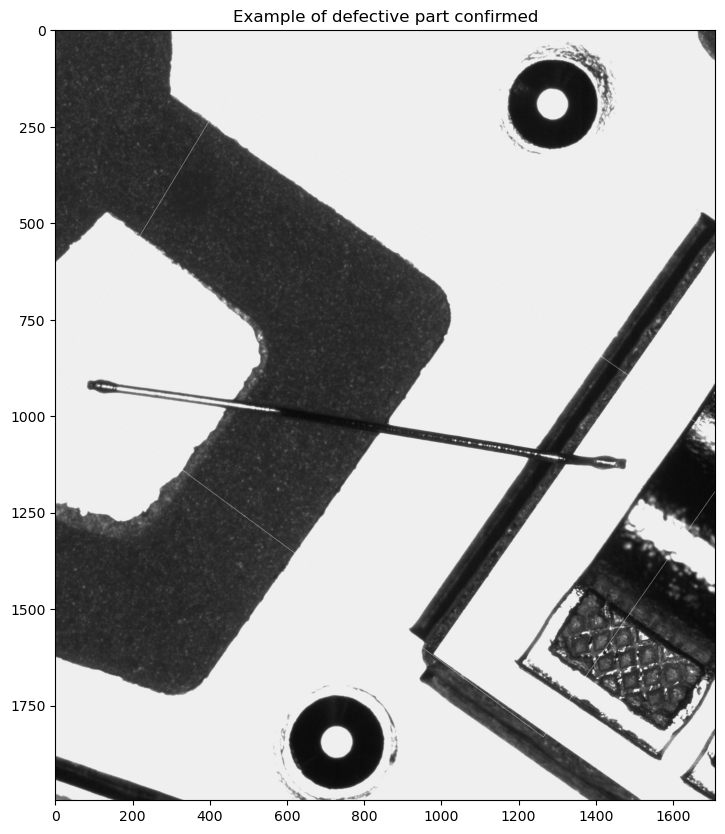

In [20]:
file2 = random.choice(list_confirmed["images"])
plt.figure(figsize=(10,10))
plt.title ("Example of defective part confirmed")
img2 = cv2.imread(file2)
plt.imshow(img2);

# Training

### Split of the dataset between training and test

In [21]:
X_train_path, X_test_path, y_train, y_test = train_test_split(df_train_data["images"], df_train_data["labels"], test_size=0.2, random_state=123)

### Loading of the images from Test Dataset and resizing

In [22]:
X_test = []
for filepath in X_test_path:
    # Read the file
    im = tf.io.read_file(filepath)
    # Decode the file
    im = tf.image.decode_jpeg(im, channels=3)
    # Resizing
    im = tf.image.resize(im, size=(256,256))
    X_test.append([im])
    
X_test = tf.concat(X_test, axis=0)

2025-02-06 16:01:18.674198: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-02-06 16:02:42.178787: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 1668808704 exceeds 10% of free system memory.


### Creation of the dataset_train

In [23]:
def load_image(filepath, resize=(256,256)):
    im = tf.io.read_file(filepath)
    im = tf.image.decode_jpeg(im, channels=3)
    return tf.image.resize(im, resize)

In [24]:
dataset_train =  tf.data.Dataset.from_tensor_slices((X_train_path, y_train))

In [25]:
dataset_train = dataset_train.map(lambda x, y : [load_image(x), y], num_parallel_calls=-1).batch(32)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


# VGG16 model

In [26]:
from keras.applications.vgg16 import VGG16
from keras.models import Model, Sequential
from keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D
from keras.optimizers import Adam

In [27]:
# Definition of the model
base_model = VGG16(weights='imagenet', include_top=False) 

n_class = 2 # 

# Freezing of the layers
for layer in base_model.layers: 
    layer.trainable = False

model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D()) 
model.add(Dense(1024,activation='relu'))
model.add(Dropout(rate=0.2))
model.add(Dense(512, activation='relu'))
model.add(Dropout(rate=0.2))
model.add(Dense(n_class, activation='softmax'))

### Compilation

In [28]:

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['acc'])

### Training of the model

In [30]:
history = model.fit(dataset_train, epochs = 5, validation_data = (X_test, y_test))

Epoch 1/5
266/266 [==============================] - 852s 3s/step - loss: 0.4495 - acc: 0.9097 - val_loss: 0.1103 - val_acc: 0.9717
Epoch 2/5
266/266 [==============================] - 832s 3s/step - loss: 0.1274 - acc: 0.9602 - val_loss: 0.1115 - val_acc: 0.9769
Epoch 3/5
266/266 [==============================] - 826s 3s/step - loss: 0.1022 - acc: 0.9697 - val_loss: 0.0962 - val_acc: 0.9760
Epoch 4/5
266/266 [==============================] - 831s 3s/step - loss: 0.0926 - acc: 0.9738 - val_loss: 0.1007 - val_acc: 0.9774
Epoch 5/5
266/266 [==============================] - 833s 3s/step - loss: 0.0856 - acc: 0.9747 - val_loss: 0.1259 - val_acc: 0.9760


### Saving

In [31]:
model.save("/media/jacquin/STOCKAGE/DATA_SCIENCE/DATA_VALEO/MODEL/modelVGG16")

INFO:tensorflow:Assets written to: /media/jacquin/STOCKAGE/DATA_SCIENCE/DATA_VALEO/MODEL/modelVGG16/assets


INFO:tensorflow:Assets written to: /media/jacquin/STOCKAGE/DATA_SCIENCE/DATA_VALEO/MODEL/modelVGG16/assets


In [36]:
model.save("/media/jacquin/STOCKAGE/DATA_SCIENCE/DATA_VALEO/MODEL/modelVGG16-2.h5")

In [37]:
model.save_weights("/media/jacquin/STOCKAGE/DATA_SCIENCE/DATA_VALEO/MODEL/modelVGG16weights-2.h5")

### Plotting of the loss and accuracy in function of the epoch

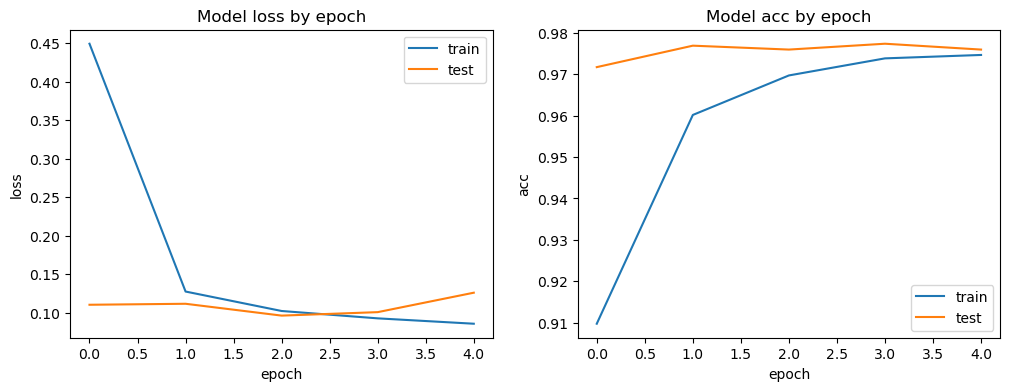

In [38]:
# Courbe de la fonction de coût et de précision en fonction de l'epoch.
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss by epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')

plt.subplot(122)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model acc by epoch')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

# Post-processing

### Probality calculation

In [ ]:
y_prob = model.predict(X_test)

67/67 [==============================] - 169s 3s/step


#### To predict the class of the image, we search the class for which the probabilty is maximum.

In [41]:
y_pred = tf.argmax(y_prob, axis=-1).numpy()

### Metrics

In [43]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report


In [59]:
accuracy_score = accuracy_score(y_test, y_pred)
print("accuracy score:", "%.3f" % accuracy_score)

accuracy score: 0.976


In [60]:
confusion_matrix(y_test, y_pred)

array([[ 771,   49],
       [   2, 1300]])

In [61]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.94      0.97       820
           1       0.96      1.00      0.98      1302

    accuracy                           0.98      2122
   macro avg       0.98      0.97      0.97      2122
weighted avg       0.98      0.98      0.98      2122



### Display of the predictions

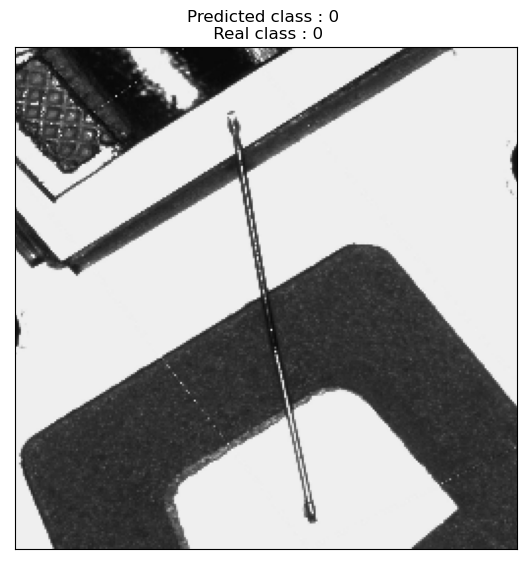

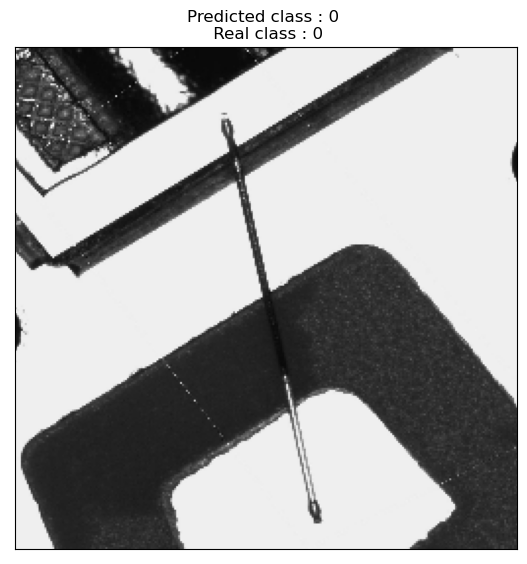

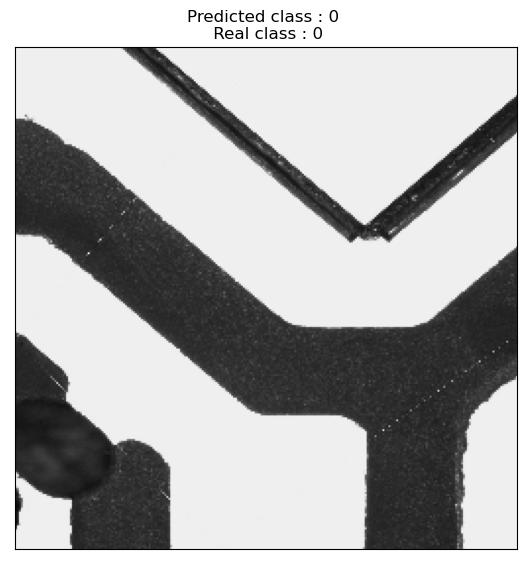

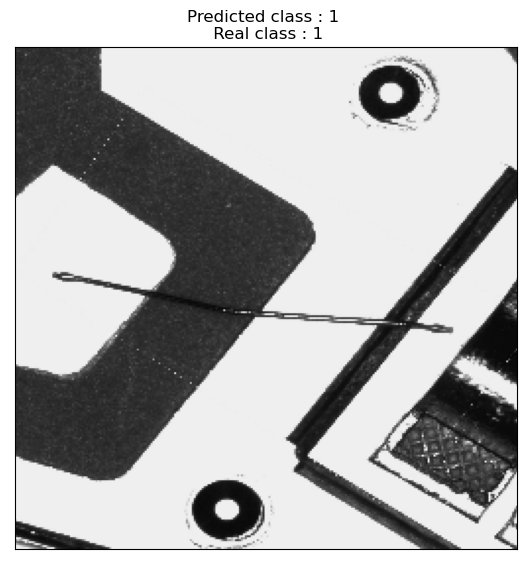

In [83]:
indices_random = tf.random.uniform([4], 0, len(X_test), dtype=tf.int32)
for i, idx in enumerate(indices_random):
    plt.figure(figsize=(30, 30))
    plt.subplot(4, 1, i+1)
    plt.imshow(tf.cast(X_test[idx], tf.int32))
    plt.xticks([])
    plt.yticks([])
    plt.title('Predicted class : {} \n Real class : {}'.format(y_pred[idx], y_test.values[idx]))